In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2

# Data Prep

In [16]:
# Load dataset
df = pd.read_csv("data/bank_churn/train.csv")

In [17]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [18]:
# Drop unnecessary columns
df = df.drop(columns=["id", "CustomerId", "Surname"])

In [19]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [22]:
# EDA: check null value and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CreditScore        165034 non-null  int64  
 1   Gender             165034 non-null  int64  
 2   Age                165034 non-null  float64
 3   Tenure             165034 non-null  int64  
 4   Balance            165034 non-null  float64
 5   NumOfProducts      165034 non-null  int64  
 6   HasCrCard          165034 non-null  float64
 7   IsActiveMember     165034 non-null  float64
 8   EstimatedSalary    165034 non-null  float64
 9   Exited             165034 non-null  int64  
 10  geography_France   165034 non-null  bool   
 11  geography_Germany  165034 non-null  bool   
 12  geography_Spain    165034 non-null  bool   
dtypes: bool(3), float64(5), int64(5)
memory usage: 13.1 MB


In [23]:
# EDA: check data stats
df.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,0.435571,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,0.495833,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,0.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,0.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,1.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


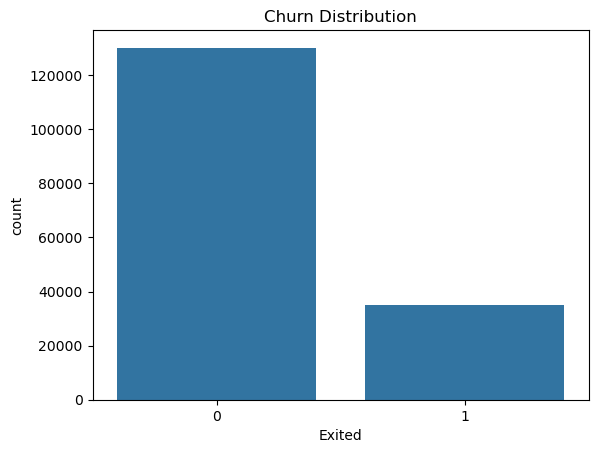

In [24]:
# EDA: check churn distribution
sns.countplot(x='Exited', data=df)
plt.title('Churn Distribution')
plt.show()

In [21]:
# Encode categorical variables
df['Gender'] = df['Gender'].replace({'Female': 1, 'Male': 0})
df = pd.get_dummies(df, columns=['Geography'], prefix='geography')

C:\Users\Apits\AppData\Local\Temp\ipykernel_29800\2353084631.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'Female': 1, 'Male': 0})


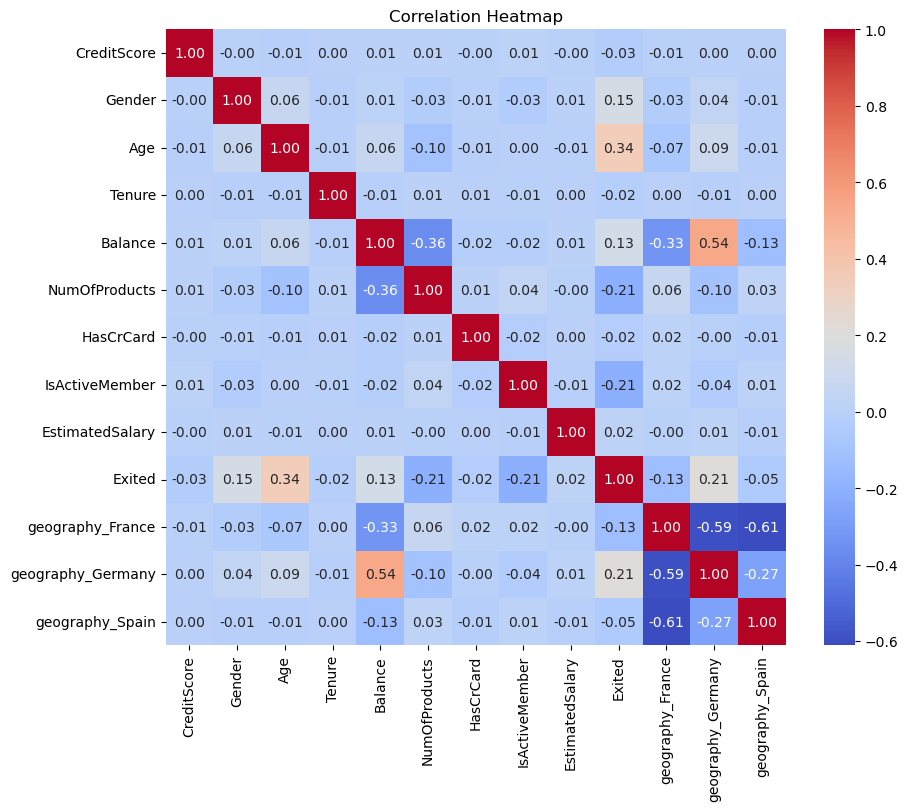

In [26]:
# EDA: check confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [27]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,geography_France,geography_Germany,geography_Spain
0,668,0,33.0,3,0.00,2,1.0,0.0,181449.97,0,True,False,False
1,627,0,33.0,1,0.00,2,1.0,1.0,49503.50,0,True,False,False
2,678,0,40.0,10,0.00,2,1.0,0.0,184866.69,0,True,False,False
3,581,0,34.0,2,148882.54,1,1.0,1.0,84560.88,0,True,False,False
4,716,0,33.0,5,0.00,2,1.0,1.0,15068.83,0,False,False,True


# Feature Engineering

In [28]:
# Split features and target
X = df.drop(columns=["Exited"])
y = df["Exited"]

In [29]:
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,geography_France,geography_Germany,geography_Spain
0,668,0,33.0,3,0.00,2,1.0,0.0,181449.97,True,False,False
1,627,0,33.0,1,0.00,2,1.0,1.0,49503.50,True,False,False
2,678,0,40.0,10,0.00,2,1.0,0.0,184866.69,True,False,False
3,581,0,34.0,2,148882.54,1,1.0,1.0,84560.88,True,False,False
4,716,0,33.0,5,0.00,2,1.0,1.0,15068.83,False,False,True


In [30]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Exited, dtype: int64

In [31]:
# Scaling
robust_features = ['Balance', 'EstimatedSalary']
standard_features = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
categorical_features = ['Gender'] + [col for col in X.columns if col.startswith('geography')]

scaler = ColumnTransformer([
    ('robust', RobustScaler(), robust_features),
    ('standard', StandardScaler(), standard_features)
], remainder='passthrough')

X_scaled = scaler.fit_transform(X)

In [33]:
X_scaled

array([[0.0, 0.7886983896365267, 0.14413458753651417, ..., True, False,
        False],
       [0.0, -0.8500849175147991, -0.3677057922533312, ..., True, False,
        False],
       [0.0, 0.8311342630722471, 0.2689737045584277, ..., True, False,
        False],
       ...,
       [0.0, 0.11776156083413009, -1.141708317789195, ..., True, False,
        False],
       [1.3467871421110227, -0.5809480164835334, -1.2790313465132999,
        ..., False, False, True],
       [0.0, -0.7000718096921132, 2.41620651733534, ..., True, False,
        False]], dtype=object)

In [34]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
# Address class imbalance
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Model Training

In [37]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss'),
    "LGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
}

In [38]:
results = {}
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    print(f"\n{name}\n", classification_report(y_test, y_pred), 
          f"Accuracy: {results[name]['Accuracy']:.4f}",
          f"F1: {results[name]['F1']:.4f}",
          f"ROC-AUC: {results[name]['ROC-AUC']:.4f}" if y_prob is not None else "")


Logistic Regression
               precision    recall  f1-score   support

           0       0.91      0.76      0.83     26023
           1       0.45      0.73      0.56      6984

    accuracy                           0.76     33007
   macro avg       0.68      0.75      0.70     33007
weighted avg       0.82      0.76      0.77     33007
 Accuracy: 0.7555 F1: 0.5593 ROC-AUC: 0.8159

Random Forest
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     26023
           1       0.64      0.63      0.63      6984

    accuracy                           0.85     33007
   macro avg       0.77      0.77      0.77     33007
weighted avg       0.84      0.85      0.85     33007
 Accuracy: 0.8452 F1: 0.6330 ROC-AUC: 0.8697

XGBoost
               precision    recall  f1-score   support

           0       0.90      0.92      0.91     26023
           1       0.68      0.63      0.65      6984

    accuracy                           0.86   

# Evaluation

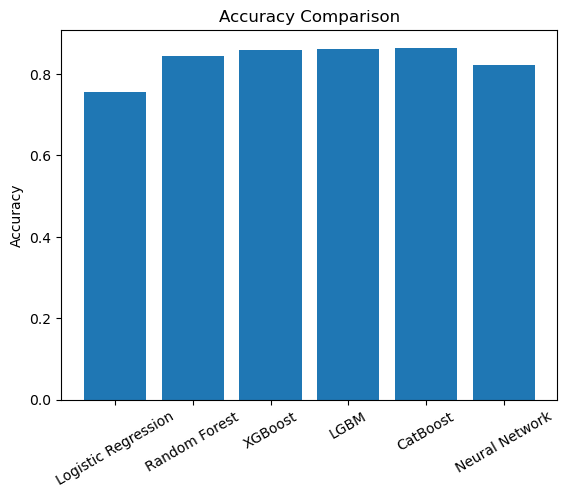

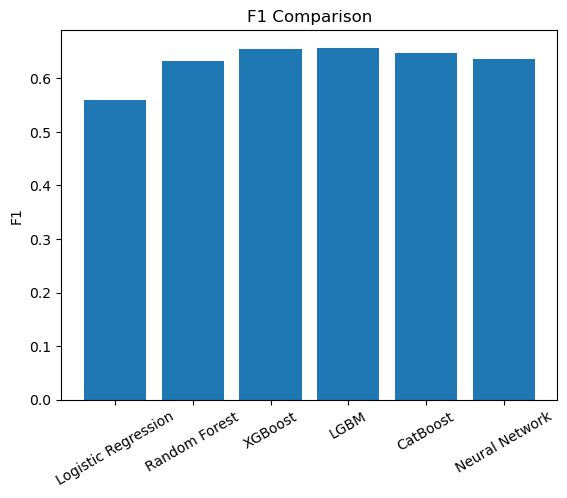

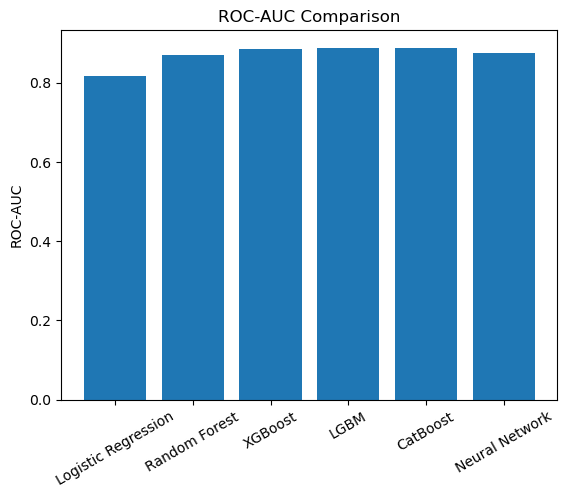

In [39]:
# Compare models
metrics = ["Accuracy", "F1", "ROC-AUC"]
for metric in metrics:
    vals = [results[m][metric] for m in models if results[m][metric] is not None]
    plt.bar(models.keys(), vals)
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xticks(rotation=30)
    plt.show()

Ranking Model:
1. LightGBM: Best overall performance (86.18% accuracy)
2. CatBoost: Highest precision but lower recall
3. XGBoost: Close second with 85.86% accuracy
4. Logistic Regression: Baseline performance (75.55% accuracy)

# Feature Selection

In [42]:
X_cat = df[categorical_features]
y_cat = df['Exited']

chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_cat, y_cat)

chi2_scores = chi2_selector.scores_  # scores
features = X_cat.columns              # feature names

# Map feature names to their chi2 scores and print them
feature_scores = list(zip(features, chi2_scores))
for feature, score in feature_scores:
    print(f"Feature: {feature}, Chi2 Score: {score}")

Feature: Gender, Chi2 Score: 1997.6138770920807
Feature: geography_France, Chi2 Score: 1211.5622513832982
Feature: geography_Germany, Chi2 Score: 5809.742503899883
Feature: geography_Spain, Chi2 Score: 337.3690099617113


### Top Features Business Interpretation
- Geography_Germany (Chi2 = 5809.74): Highest churn risk - suggests market-specific challenges requiring immediate strategic attention and Germany-focused retention programs.
- Gender (Chi2 = 1997.61): Significant demographic factor - females show higher churn rates indicating need for gender-targeted retention strategies.
- Geography_France & Spain: Moderate and low churn risks respectively, with Spain representing the most stable customer base.

In [45]:
models = {
    "LGBM": LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X_cat, y_cat, scoring='roc_auc', cv=cv)
    print(f"{name} CV ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

C:\Users\Apits\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Apits\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Apits\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Apits\anaconda3\Lib\site-packages\

XGBoost CV ROC-AUC: 0.6580 ± 0.0012
CatBoost CV ROC-AUC: 0.6580 ± 0.0012


### All Features vs Selected Features Analysis
Using all features achieves higher ROC-AUC because:
- Tree-based models (LightGBM, XGBoost, CatBoost) excel at capturing complex feature interactions that Chi-Square tests miss
- Even low-scoring features contribute valuable information in combination with others
- Complete feature sets provide ensemble models with diverse information sources for more stable predictions

This demonstrates that statistical feature selection methods may underestimate the collective predictive power available to sophisticated ensemble algorithms.